In this script is the data smoothen after the PC are constructed 

In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import math
#for removing warnings
import warnings

In [3]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [4]:
dset = open_s3fs('PC-data')
dset

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [5]:
# Smoothen data, over every tenth point in both x and y direction, for all the data
vvar = dset.vomecrty.isel(y=slice(900,1800), x=slice(200,1400))
uvar = dset.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400))
uv = dset.vel.isel(y=slice(900,1800), x=slice(200,1400))


In [152]:
# Getting the bottom velocity 
d = dset.mbathy.isel(y=slice(900,1800), x=slice(200,1400)).values-1
d[d==-1] = 0

d = xr.DataArray(d, dims=['y','x'])

uvar_b = uvar.isel(depth=d)
vvar_b = vvar.isel(depth=d)
uv_b = uv.isel(depth=d)

In [ ]:
# List of x,y elements
dx = 20
dy = 20

scale = 2e3

jmax, imax = uv_b.shape
i_list = np.arange(0,imax,dx)
j_list = np.arange(0,jmax,dy)

# Making the covmatrix and finding the eigenvalues and eigenvectors
# ----------------------------------------------------------------------
y = []
x = []

#ellipser:
theta_l = []
minor_l = []
major_l = []
indx = 0

# to get the loop to run faster
uvy = np.array(uv_b.y.values)
uvx = np.array(uv_b.x.values)


uvarb = np.array(uvar_b.values)
vvarb = np.array(vvar_b.values)
uvb = np.array(uv_b.values)

for i in i_list:
    for j in j_list:
        covm = np.array([[uvarb[j,i],uvb[j,i]],
        [uvb[j,i],vvarb[j,i]]],dtype=float)
        if np.isnan(covm).any():
            continue
        else:
            # Find and sort eigenvalues and eigenvectors into descending order
                values, vectors = np.linalg.eig(covm)
                order = values.argsort()[::-1]
                values, vectors = values[order], vectors[:, order]

                # center of ellipse
                y.append(uvy[j])
                x.append(uvx[i])

                # ellipser :
                major = np.sqrt(values[0])*scale
                minor = np.sqrt(values[1])*scale

                major_l.append(major)
                minor_l.append(minor)
                #major_info.append(values[0])

                # The anti-clockwise angle to rotate our ellipse by 
                vx, vy = vectors[:,0][0], vectors[:,0][1]
                theta = np.arctan2(vy, vx)*(180/math.pi)
                theta_l.append(theta)

                indx = indx + 1

# converting to np.arrays
y = np.array(y,dtype=float)
x = np.array(x,dtype=float)




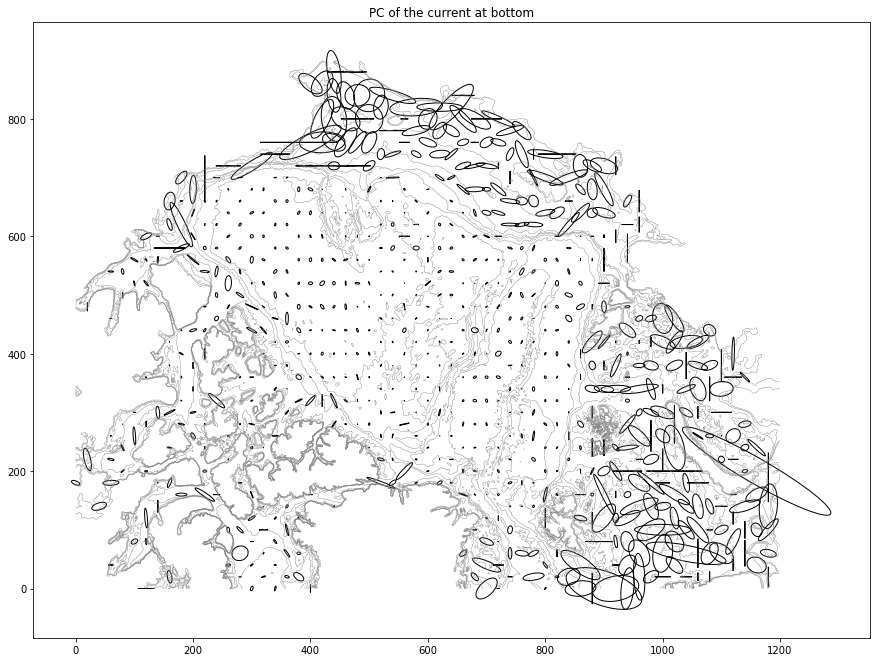

In [146]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1,1,figsize=(15,15))
n = 2
plt.title(f'PC of the current at bottom')
ax.contour(dset.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

for i in range(int(len(x)/2)):
    ellipse = Ellipse((x[i*2],y[i*2]), 
                      width = major_l[i*2], 
                      height = minor_l[i*2],
                      angle = theta_l[i*2]*(180/math.pi),
                      facecolor = 'none',
                      edgecolor='k')
    ax.add_patch(ellipse)

#ax.plot((expr[::n]+xe[::n]),(eypr[::n]+ye[::n]),'r',(exmr[::2]+xe[::2]),(eymr[::n]+ye[::n]),'r')

ax.set_aspect('equal')
plt.show()

### Figure of the bottom currents in the Arctic ocean. 
The variance ellipces on the shelf and Barents sea are the largest ones, hence it is here we can find the largest spread in the currents direction. This correspond with the depth, where the shelf and the Barents sea is where it is shallowest. The variance ellipses away from boundaries are significant smaller, thus the currents are more stable in directions. Around the whole Arctic ocean we can see that the variance ellipses close to the sloping boundaries are alligned with the topography.  